#### Notebook to analyse the distribution of systematics in pixels where Linear and DeepSet deviate

In [1]:
import pandas as pd
import time
import pickle
from models.deep_set.set_dataloader import CCD
import matplotlib.pyplot as plt
import healpy as hp
from astropy.io import fits
import numpy as np


Steps:

1. Separate corpus by extreme difference in linear and deep

In [2]:
gals = ['lrg', 'elg', 'qso']
areas = ['north', 'south', 'des']

uni_metrics = {"EBV", "stellar", "airmass", "filter"}

zscore = lambda x: abs((x - x.median()) / x.std())


In [ ]:
# Calculating the Z-value difference between Deep and Linear Models
area = 'north'
gal = 'elg'


df_test = pd.read_csv(f'results/{area}_complete.csv')
df_test[f'{gal}_LINEAR_VS_DEEP'] = df_test[f'{gal}_lin'] - df_test[f'{gal}_deep']


df_test[f'{gal}_Z'] = df_test[f'{gal}_LINEAR_VS_DEEP'].transform(zscore)

print(df_test[f'{gal}_Z'])

print(df_test.columns)

In [4]:
# Separating into two corpus

In [5]:
df_diff = df_test[df_test[f'{gal}_Z'] > 2]
df_no_diff = df_test[df_test[f'{gal}_Z'] <= 2]

print(len(df_diff))
print(len(df_no_diff))
print(len(df_diff)/len(df_no_diff))
print(df_diff.head())

3443
94069
0.036600793034899916
    pixel_id  lrg  elg  qso  exposures   stellar       EBV   airmass  \
5      82226   24  139  136   0.272727  0.389121  0.691390  0.269643   
12     13805   33  148  191   0.202797  0.104603  0.104795  0.455058   
22     88025   33  122  150   0.279720  0.230126  0.278899  0.079172   
39    185223   15   83   91   0.615385  0.037657  0.076639  0.628326   
51     21577   22  107  104   0.216783  0.096234  0.144741  0.327416   

    ccdskysb_g  ccdskysb_r  ...      elg_nn      qso_nn   lrg_deep  y_gold_x  \
5     0.669890    0.504869  ...  112.357765  137.443802  39.370529      24.0   
12    0.798852    0.453930  ...  122.563126  159.401733  34.844891      33.0   
22    0.641070    0.557464  ...  121.627251  136.937286  37.247723      33.0   
39    0.674481    0.585174  ...  126.687256  116.244797  33.838257      15.0   
51    0.820230    0.724263  ...  122.315102  154.590851  35.375160      22.0   

      elg_deep  y_gold_y    qso_deep  y_gold  elg_LINE

2. Identify all CCDs that cover a given pixel in deepset --> use set for that

A. Get all Subpixels for the pixels in the DF
B. Get all CCDs for all these subpixels and create a set

In [6]:
time_start = time.time()

# For DECAM, BASS, MzLS
with open('../../bricks_data/pixel2ccd_256.pickle', 'rb') as f:
    pixel2ccd_dict = pickle.load(f)
    f.close()

time_end = time.time()
time_passed = time_end - time_start
print()
print(f"{time_passed / 60:.5} minutes ({time_passed:.3} seconds) taken to import the dict")
print()


0.065434 minutes (3.93 seconds) taken to import the dict



In [7]:


decamCCD = fits.open('../../bricks_data/ccds-annotated-decam-dr9.fits')
mosaicCCD = fits.open('../../bricks_data/ccds-annotated-mosaic-dr9.fits')
bassCCD = fits.open('../../bricks_data/ccds-annotated-90prime-dr9.fits')
dataDecam = decamCCD[1].data
dataMosaic = mosaicCCD[1].data
dataBass = bassCCD[1].data

ra0 = np.concatenate((dataDecam.field('ra0'), dataMosaic.field('ra0'), dataBass.field('ra0')), axis=0)
dec0 = np.concatenate((dataDecam.field('dec0'), dataMosaic.field('dec0'), dataBass.field('dec0')), axis=0)

ra1 = np.concatenate((dataDecam.field('ra1'), dataMosaic.field('ra1'), dataBass.field('ra1')), axis=0)
dec1 = np.concatenate((dataDecam.field('dec1'), dataMosaic.field('dec1'), dataBass.field('dec1')), axis=0)

ra2 = np.concatenate((dataDecam.field('ra2'), dataMosaic.field('ra2'), dataBass.field('ra2')), axis=0)
dec2 = np.concatenate((dataDecam.field('dec2'), dataMosaic.field('dec2'), dataBass.field('dec2')), axis=0)

ra3 = np.concatenate((dataDecam.field('ra3'), dataMosaic.field('ra3'), dataBass.field('ra3')), axis=0)
dec3 = np.concatenate((dataDecam.field('dec3'), dataMosaic.field('dec3'), dataBass.field('dec3')), axis=0)


In [8]:
pix_ids = list(df_diff.pixel_id)

[6392251, 6392252, 6393131, 6481923, 6481924, 6633590, 6664110, 6673967, 6673968, 6673969, 6673970, 6675762, 6708211, 6708212, 6708213, 6708214, 6714510, 6754666]
Number of CCDs that are cutting pixel number  168730 : 18


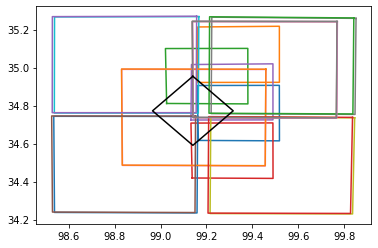

In [9]:
pixel_number = pix_ids[2000]

ccd = pixel2ccd_dict[pixel_number]
print(ccd)
print("Number of CCDs that are cutting pixel number ", pixel_number, ":", len(ccd))
for cc in ccd:
    xs = [ra0[cc], ra1[cc], ra2[cc], ra3[cc], ra0[cc]]
    ys = [dec0[cc], dec1[cc], dec2[cc], dec3[cc], dec0[cc]]
    plt.plot(xs, ys)

pixel_boundary = hp.boundaries(nside=256, pix=pixel_number, step=1)
pixel_boundary_raDec = hp.vec2ang(pixel_boundary.transpose(), lonlat=True)
pixel_boundary_raDec = list(pixel_boundary_raDec)
pixel_boundary_raDec[0] = np.append(pixel_boundary_raDec[0], pixel_boundary_raDec[0][0])
pixel_boundary_raDec[1] = np.append(pixel_boundary_raDec[1], pixel_boundary_raDec[1][0])

plt.plot(pixel_boundary_raDec[0], pixel_boundary_raDec[1], c='black', label="Pixel Boundary")

plt.show()


In [10]:
ccd_ids = set()

ccds_per_pix = 0
for id in pix_ids:
    ccds_per_pix += len(pixel2ccd_dict[id])
    # Iterate through all Pixels with large deviations in prediction
    for elem in pixel2ccd_dict[id]:
        # Add all CCDs to the set --> only unique one's will be retained
        ccd_ids.add(elem)

print(len(ccd_ids))

print("Average CCDs per pixel in no_diff", ccds_per_pix/len(df_diff))




86383
Average CCDs per pixel in no_diff 46.8370607028754


In [11]:
ccd = CCD()

# Get the available data for the list CCD ids in the deviating set

data = ccd.get_ccds(list(ccd_ids))

print(data)

[['195.0' '2.17' '1.4432356' '20.147465' '2.4538672' 'z']
 ['195.0' '2.17' '1.4206523' '20.146729' '2.453416' 'z']
 ['195.0' '2.17' '1.4282845' '20.143763' '2.443515' 'z']
 ...
 ['166.0' '2.14' '1.2092987' '20.207922' '2.5305955' 'z']
 ['109.927' '1.21' '0.93009996' '23.342793' '0.2822703' 'g']
 ['109.927' '1.21' '0.88293993' '23.344662' '0.28262067' 'g']]


In [12]:
df = pd.DataFrame(data, columns=['exptime',
                          'airmass',
                          'seeing',
                          'ccdskysb',
                          'meansky',
                           'filter'])

df.head()

,exptime,airmass,seeing,ccdskysb,meansky,filter
0,195.0,2.17,1.4432356,20.147465,2.4538672,z
1,195.0,2.17,1.4206523,20.146729,2.453416,z
2,195.0,2.17,1.4282845,20.143763,2.443515,z
3,195.0,2.17,1.4521575,20.145058,2.4430056,z
4,195.0,2.17,1.4803694,20.14509,2.4630578,z



3. Plot difference in inputs for all pixels in each catalogue


In [13]:

nrows = 6
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 18))
#plt.title("Raw Test Set Systematics Dependency - North")
#fig = plt.figure()
i = 0

col = df.columns
for ax in ax.flatten():


    x_label = col[i]
    plt.axes(ax)

    if x_label == 'airmass' or x_label ==
    plt.hist(df[x_label])
    plt.xlabel(x_label)
    i+=1

fig.tight_layout(pad=3.0)

plt.show()


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fdeecf6ddc0> (for post_execute):


KeyboardInterrupt: 

Repeat the same for the pixels that do not have a large difference

In [ ]:
pix_ids = list(df_no_diff.pixel_id)
ccd_ids = set()

ccds_per_pix = 0
for id in pix_ids:
    ccds_per_pix += len(pixel2ccd_dict[id])
    # Iterate through all Pixels with large deviations in prediction
    for elem in pixel2ccd_dict[id]:
        # Add all CCDs to the set --> only unique one's will be retained
        ccd_ids.add(elem)

print(len(ccd_ids))

print("Average CCDs per pixel in no_diff", ccds_per_pix/len(df_no_diff))


In [ ]:
ccd = CCD()

# Get the available data for the list CCD ids in the deviating set

data = ccd.get_ccds(list(ccd_ids))

print(data)

In [ ]:
df = pd.DataFrame(data, columns=['exptime',
                          'airmass',
                          'seeing',
                          'ccdskysb',
                          'meansky',
                           'filter'])

df.head()


3. Plot difference in inputs for all pixels in each catalogue


In [ ]:
nrows = 6
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 18))
#plt.title("Raw Test Set Systematics Dependency - North")
#fig = plt.figure()
i = 0

col = df.columns
for ax in ax.flatten():
    x_label = col[i]

    plt.axes(ax)
    plt.hist(df[x_label])
    plt.xlabel(x_label)
    i+=1

fig.tight_layout(pad=3.0)

plt.show()
